<a href="https://colab.research.google.com/github/grtushar/word2vec/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [19]:
import numpy as np
import re
import string
import nltk
import os
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
from nltk.corpus import stopwords 

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.preprocessing.text import Tokenizer
from numpy.lib.function_base import vectorize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Cleaning Special Characters and Removing Punctuations

In [20]:
# Some preprocesssing that will be common to all the text classification methods you will see.

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

# Cleaning Numbers

In [21]:
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

# Removing Contractions

In [22]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Utility Functions

In [23]:
def get_corpus():
  corpus_dir = './data/RNN/'
  corpus_text_file = os.path.join(corpus_dir, 'en.wikipedia.2010.100K.txt')

  if not os.path.isfile( corpus_text_file ):
    if not os.path.exists(corpus_dir):
        os.makedirs(corpus_dir)

    corpus_text_tar = 'eng_wikipedia_2010_100K.tar.gz'    
    download_url = 'http://pcai056.informatik.uni-leipzig.de/downloads/corpora/'+corpus_text_tar

    data_cache = './data/cache'
    if not os.path.exists(data_cache):
        os.makedirs(data_cache)
    
    # Fall-back url if too slow
    #download_url= 'http://redcatlabs.com/downloads/deep-learning-workshop/notebooks/data/RNN/'+corpus_text_tar

    import shutil, requests

    # Get the download path from the web-service
    #urllib.request.urlretrieve('http://wortschatz.uni-leipzig.de/download/service', corpus_text_tar)
    # download_url = ...
    
    tarfilepath = os.path.join(data_cache, corpus_text_tar)
    if not os.path.isfile( tarfilepath ):
        response = requests.get(download_url, stream=True)
        with open(tarfilepath, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
    if os.path.isfile(tarfilepath):
        import tarfile
        #tarfile.open(tarfilepath, 'r:gz').extractall(corpus_dir)
        tarfile.open(tarfilepath, 'r:gz').extract('eng_wikipedia_2010_100K-sentences.txt', corpus_dir)
    shutil.move(os.path.join(corpus_dir, 'eng_wikipedia_2010_100K-sentences.txt'), corpus_text_file)
    
    # Get rid of tarfile source (the required text file itself will remain)
    #os.unlink(tarfilepath)

  print("Corpus available locally")

  while True:
    corpus = ''
    number_of_lines = 0
    with open(corpus_text_file, encoding='utf-8') as f:
      for line in f.readlines():
          n,l = line.split('\t')   # Strip of the initial numbers
          corpus += l
          number_of_lines += 1
          if(number_of_lines == 10):
            return corpus
  
  return ''

# Sample Input:
# Sample Output:
def word_to_one_hot_vector(word_idx, vocab_size):
  one_hot_vector = np.zeros(vocab_size)
  one_hot_vector[word_idx] = 1
  return one_hot_vector

# Sample Input:
# Sample Output:
def extract_vacoab_info(text):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts([text])
  return len(tokenizer.word_index), tokenizer.word_index, dict(map(reversed, tokenizer.word_index.items()))

# Sample Input:
# Sample Output:
def split_sentence(corpus):
    stop_words = set(stopwords.words('english'))    
    training_data = []
    sentences = corpus.split(".")
    for i in range(len(sentences)):
        sentences[i] = sentences[i].strip()
        sentence = sentences[i].split()
        x = [word.strip(string.punctuation) for word in sentence if word not in stop_words]
        x = [word.lower() for word in x if word != '']
        training_data.append(x)
    return training_data

# Sample Input:
# Sample Output:
def prepare_training_data(sentences, window_size, vocab, vocab_size):
  training_data = []
  for sentence in sentences:
    sent_len = len(sentence)
    for i, word in enumerate(sentence):
      target_word = word_to_one_hot_vector(vocab[sentence[i]] - 1, vocab_size)
      
      word_context = []
      for j in range(i - window_size, i + window_size+1):
        if j != i and j <= sent_len-1 and j >= 0:
          word_context.append(word_to_one_hot_vector(vocab[sentence[j]] - 1, vocab_size))
      training_data.append([target_word, word_context])
  return np.array(training_data)

def plot_vectors(wordVectors=wordVectors):
  visualizeWords = ["the", "a", "that", 'this', 'her', 'present', 'day', 'take', 'police', 'officers']
  print(vocab)
  visualizeIdx = [vocab[word] for word in visualizeWords]
  visualizeVecs = wordVectors[visualizeIdx, :]
  temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
  covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
  U,S,V = np.linalg.svd(covariance)
  coord = temp.dot(U[:,0:2]) 

  for i in range(len(visualizeWords)):
      plt.text(coord[i,0], coord[i,1], visualizeWords[i], bbox=dict(facecolor='green', alpha=0.1))
      
  plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
  plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

# CBOW and Skip-gram Implementaion

In [24]:
class word2Vec:
  def __init__(self, window_size, vocab, vocab_size, idx2word, embedding_dim, word_context, target_word, model):
    self.window_size = window_size
    self.vocab = vocab
    self.vocab_size = vocab_size
    self.idx2word = idx2word
    self.embedding_dim = embedding_dim
    self.optimizer = tf.optimizers.SGD(learning_rate=0.1)
    self.alpha = 0.1
    self.model = model
    self.__set_var_depending_on_model(word_context, target_word);

  def __set_var_depending_on_model(self, word_context, target_word):
    if(self.__is_cbow()):
      self.X_train = word_context
      self.y_train = target_word
    else:
      self.X_train = target_word
      self.y_train = word_context

  def __is_cbow(self):
    return self.model == 'CBOW'

  def train(self, epochs):
    self.W1 = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim]))
    self.b1 = tf.Variable(tf.random.normal([self.embedding_dim])) #bias
    self.W2 = tf.Variable(tf.random.normal([self.embedding_dim, self.vocab_size]))
    self.b2 = tf.Variable(tf.random.normal([self.vocab_size]))

    for _ in range(epochs):
      with tf.GradientTape() as t:
        hidden_layer = tf.add(tf.matmul(self.X_train,self.W1),self.b1)
        output_layer = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, self.W2), self.b2))
        cross_entropy_loss = tf.reduce_mean(-tf.math.reduce_sum(self.y_train * tf.math.log(output_layer), axis=[1]))
      grads = t.gradient(cross_entropy_loss, [self.W1, self.b1, self.W2, self.b2])
      self.optimizer.apply_gradients(zip(grads,[self.W1, self.b1, self.W2, self.b2]))
      if(_ % 1000 == 0):
        print(cross_entropy_loss)

  def train_using_numpy(self, epochs):
    self.W1 = np.random.uniform(-0.8, 0.8, (self.vocab_size, self.embedding_dim))
    self.W2 = np.random.uniform(-0.8, 0.8, (self.embedding_dim, self.vocab_size))
    #self.b1 = np.random.uniform(-0.8, 0.8, self.embedding_dim) #np.zeros(self.embedding_dim)
    #self.b2 = np.random.uniform(-0.8, 0.8, self.vocab_size) #np.zeros(self.vocab_size)

    if(self.__is_cbow()):
      self.__train_CBOW_model(epochs)
    else:
      self.__train_skip_gram_model(epochs)

  def __train_CBOW_model(self, epochs):
    for i in range(0, epochs):
        self.loss = 0

        for j in range(0, self.X_train.shape[0]):

            x = np.mean(self.X_train[j], axis=0)

            y_hat, z1, z2 = self.forward_pass(x)

            EI = np.subtract(y_hat, self.y_train[j])

            self.backprop(EI, z1, x)
            
            self.loss += -float(z2[self.y_train[j] == 1]) + np.log(np.sum(np.exp(z2)))
            # self.loss += self.calculate_loss(y_hat, self.y_train[j])

        if(i % 1000 == 0):
          print('EPOCH:',i, 'LOSS:', self.loss)
    pass

  def __train_skip_gram_model(self, epochs):
    for i in range(0, epochs):
        self.loss = 0

        for j in range(0, self.X_train.shape[0]):
            x = self.X_train[j]

            y_hat, z1, z2 = self.forward_pass(x)

            EI = np.array([-label + y_hat.T for label in self.y_train[j]])

            self.backprop(EI, z1, x)
            
            self.loss += -np.sum([z2[label == 1] for label in self.y_train[j]]) + len(self.y_train[j]) * np.log(np.sum(np.exp(z2)))
            # self.loss += self.calculate_loss(y_hat, self.y_train[j])

        if(i % 1000 == 0):
          print('EPOCH:',i, 'LOSS:', self.loss)
    pass

  def calculate_loss(self, y_hat, y):
    # Cross Entropy Loss
    loss = -np.sum(y * np.log(y_hat))
    return loss

  # FORWARD PASS
  def forward_pass(self, x):
      z1 = np.dot(self.W1.T, x) # + self.b1
      z2 = np.dot(self.W2.T, z1) # + self.b2
      y_hat = self.softmax(z2)
      return y_hat, z1, z2

  # SOFTMAX ACTIVATION FUNCTION
  def softmax(self, x):
      e_x = np.exp(x - np.max(x))
      return e_x / e_x.sum(axis=0)

  # BACKPROPAGATION
  def backprop(self, e, h, x):
      if(self.__is_cbow()):
        dl_dw2 = np.outer(h, e)  
        dl_dw1 = np.outer(x, np.dot(self.W2, e.T))
      else:
        dl_dw2 = np.outer(h, np.sum(e, axis=0))
        dl_dw1 = np.outer(x, np.dot(self.W2, np.sum(e, axis=0)))

      # UPDATE WEIGHTS
      self.W1 = self.W1 - (self.alpha * dl_dw1)
      self.W2 = self.W2 - (self.alpha * dl_dw2)
      pass

  def get_vector_from_word(self, word):
    return (self.W1)[self.vocab[word] - 1]

  def vectorized(self, word_idx):
    return (self.W1)[word_idx]

  # calculate word1 + word2 - word3
  def check_subtract_prop(self, word1, word2, word3):
    vec1 = self.vectorized(self.vocab[word1] - 1)
    vec2 = self.vectorized(self.vocab[word2] - 1)
    vec3 = self.vectorized(self.vocab[word3] - 1)

    res = vec1 + vec2 - vec3
    closest_word_idx = -1
    mn = 99999999
    for i in range(self.vocab_size):
      # ignore the words sent to this function
      if(i == self.vocab[word1] - 1 or i == self.vocab[word2] - 1 or i == self.vocab[word3] - 1 ):
        continue

      dist = np.linalg.norm(res - self.vectorized(i))
      if(mn > dist):
        mn = dist
        closest_word_idx = i
    closest_word_idx += 1

    return self.idx2word[closest_word_idx]

  def word_with_closest_distance(self, word):
    idx = self.vocab[word] - 1
    vec = self.vectorized(idx)

    closest_word_idx = -1
    mn = 99999999
    for i in range(self.vocab_size):
      if(i == idx):
        continue
      dist = np.linalg.norm(vec - self.vectorized(i))
      if(mn > dist):
        mn = dist
        closest_word_idx = i
    closest_word_idx += 1

    return self.idx2word[closest_word_idx]

# Prepare

In [25]:
window_size = 3
embedding_dim = 5
epochs = 10000

corpus = get_corpus() 
# corpus = 'Dhaka is the capital of Bangladesh. Delhi is the capital of India. Paris is the capital of France.'
# print("Raw corpus: ", corpus)

corpus = clean_text(corpus)
# print("Corpus after cleaning: ", corpus)

corpus = clean_numbers(corpus)
# print("Corpus after cleaning numbers: ", corpus)

corpus = replace_contractions(corpus)
# print("Corpus after replacing contradictions: ", corpus)


sentences = split_sentence(corpus)
print(sentences)

vocab_size, vocab, idx2word = extract_vacoab_info(corpus)
print("Vocabulary size: ", vocab_size)
print("Vocabulary", vocab)
print("Index to word dict", idx2word)

training_data = prepare_training_data(sentences, window_size, vocab, vocab_size)

x_train = []
y_train = []
for y, x in training_data:
  x_train.append(x)
  y_train.append(y)

# print(len(x_train))
# print(len(x_train[3]))
# print(x_train[3])

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# print(x_train)
# print(y_train)

w2v_cbow = word2Vec(window_size=window_size, vocab = vocab, vocab_size=vocab_size, idx2word=idx2word, embedding_dim=embedding_dim, word_context=x_train, target_word=y_train, model='CBOW')
w2v_skip_gram = word2Vec(window_size=window_size, vocab = vocab, vocab_size=vocab_size, idx2word=idx2word, embedding_dim=embedding_dim, word_context=x_train, target_word=y_train, model='skip_gram')

Corpus available locally
[['showing', 'even', 'modern', 'warfare', 's', 's', 'dilapidated', 'fortifications', 'still', 'defensive', 'usefulness'], ['celtic', 'finally', 'cemented', 'permanent', 'home', 'would', 'see', 'huge', 'success', 'present', 'day'], ['he', 'gives', 'shuji', 'pills', 'saying', 'chise', 'needs', 'weapon', 'side', '’', 'take', 'later', 'gives', 'much', 'needed', 'maintenance'], ['in', 'areas', 'trio', 'called', 'trail', 'hand', 'called', 'pakki', 'round', 'pure', 'round'], ['more', 'police', 'officers', 'deployed', 'clashes', 'reported', 'candle', 'lit', 'vigil'], ['when', 'possible', 'often', 'follows', 'edges', 'various', 'vegetation', 'catch', 'prey', 'surprise'], ['versace', 'unique', 'among', 'italian', 'fashion', 'houses', 'due', 'frequent', 'use', 'celebrity', 'face', 'house', 'advertisements'], ['according', 'henri', 'zerner', 'work', 'freedom', 'immediacy', 'equivalent', 'renaissance', 'printmaking'], ['the', 'court', 'hearings', 'open', 'public'], ['after'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# Train

In [26]:
# w2v.train(epochs=epochs)
# # print('-----------W1-------------')
# # print(w2v.W1)
# # print('-----------b1-------------')
# # print(w2v.b1)

# print(w2v.check_subtract_prop('bangladesh', 'dhaka', 'delhi'))
# # print(w2v.vectorized(6))
# print(w2v.word_with_closest_distance('dhaka'))
# print(w2v.word_with_closest_distance('delhi'))

import time
start = time.process_time()  
w2v_cbow.train_using_numpy(epochs=epochs)
print('CBOW training time: ', time.process_time() - start)

start = time.process_time()  
w2v_skip_gram.train_using_numpy(epochs=epochs)
print('Skip-Gram training time: ', time.process_time() - start)
# print('-----------W1-------------')
# print(w2v.W1)
# print('-----------b1-------------')
# print(w2v.b1)

# print('vector of dhaka')
# print(w2v.get_vector_from_word('dhaka'))
# print('vector of delhi')
# print(w2v.get_vector_from_word('delhi'))

EPOCH: 0 LOSS: 526.3418448363464
EPOCH: 1000 LOSS: 2.4199657962338783
EPOCH: 2000 LOSS: 1.8917189020410827
EPOCH: 3000 LOSS: 1.7350717128037338
EPOCH: 4000 LOSS: 1.6588123364397216
EPOCH: 5000 LOSS: 1.613166417727868
EPOCH: 6000 LOSS: 1.5825196465739282
EPOCH: 7000 LOSS: 1.5603707689693191
EPOCH: 8000 LOSS: 1.5435221115454585
EPOCH: 9000 LOSS: 1.5302152783129888
CBOW training time:  106.01523225099999
EPOCH: 0 LOSS: 2611.380014715372
EPOCH: 1000 LOSS: 900.2532368443578
EPOCH: 2000 LOSS: 890.0748733029251
EPOCH: 3000 LOSS: 884.404156998295
EPOCH: 4000 LOSS: 890.7518327180584
EPOCH: 5000 LOSS: 889.3032163637497
EPOCH: 6000 LOSS: 889.1091151340385
EPOCH: 7000 LOSS: 884.0374618899765
EPOCH: 8000 LOSS: 884.0140723242994
EPOCH: 9000 LOSS: 879.8940682801234
Skip-Gram training time:  142.071141512


# Test

{'the': 1, 'to': 2, 'in': 3, 'and': 4, 'a': 5, 'that': 6, 'of': 7, 's': 8, 'he': 9, 'is': 10, "'": 11, 'his': 12, 'had': 13, 'this': 14, 'gives': 15, 'some': 16, 'her': 17, 'called': 18, 'round': 19, 'were': 20, 'no': 21, 'when': 22, 'it': 23, 'its': 24, 'for': 25, 'showing': 26, 'even': 27, 'modern': 28, 'warfare': 29, 'dilapidated': 30, 'fortifications': 31, 'still': 32, 'defensive': 33, 'usefulness': 34, 'celtic': 35, 'finally': 36, 'cemented': 37, 'permanent': 38, 'home': 39, 'would': 40, 'see': 41, 'huge': 42, 'success': 43, 'present': 44, 'day': 45, 'shuji': 46, 'pills': 47, 'saying': 48, 'chise': 49, 'needs': 50, 'them': 51, 'so': 52, 'weapon': 53, 'side': 54, 'won': 55, '’': 56, 't': 57, 'take': 58, 'over': 59, 'later': 60, 'much': 61, 'needed': 62, 'maintenance': 63, 'areas': 64, 'where': 65, 'trio': 66, 'trail': 67, 'hand': 68, 'pakki': 69, 'pure': 70, 'more': 71, 'than': 72, 'police': 73, 'officers': 74, 'deployed': 75, 'but': 76, 'clashes': 77, 'reported': 78, 'candle': 79,

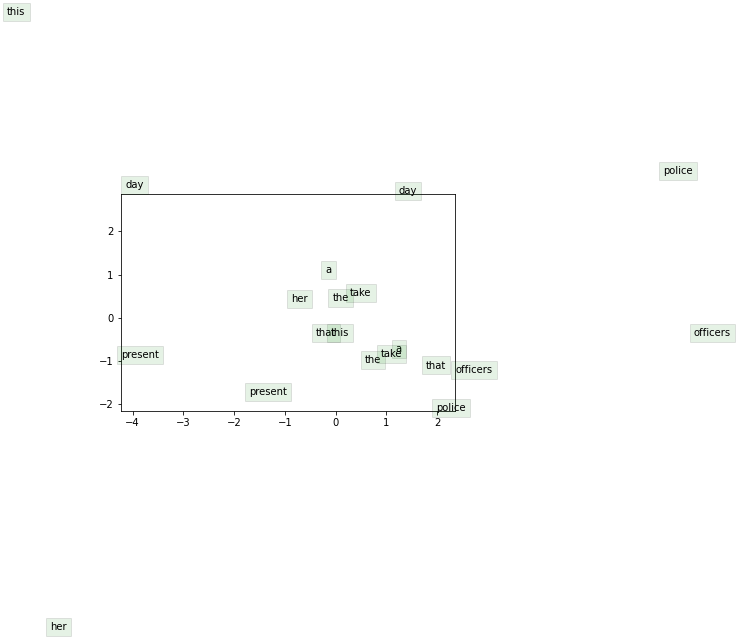

In [27]:
plot_vectors(w2v_cbow.W1)

{'the': 1, 'to': 2, 'in': 3, 'and': 4, 'a': 5, 'that': 6, 'of': 7, 's': 8, 'he': 9, 'is': 10, "'": 11, 'his': 12, 'had': 13, 'this': 14, 'gives': 15, 'some': 16, 'her': 17, 'called': 18, 'round': 19, 'were': 20, 'no': 21, 'when': 22, 'it': 23, 'its': 24, 'for': 25, 'showing': 26, 'even': 27, 'modern': 28, 'warfare': 29, 'dilapidated': 30, 'fortifications': 31, 'still': 32, 'defensive': 33, 'usefulness': 34, 'celtic': 35, 'finally': 36, 'cemented': 37, 'permanent': 38, 'home': 39, 'would': 40, 'see': 41, 'huge': 42, 'success': 43, 'present': 44, 'day': 45, 'shuji': 46, 'pills': 47, 'saying': 48, 'chise': 49, 'needs': 50, 'them': 51, 'so': 52, 'weapon': 53, 'side': 54, 'won': 55, '’': 56, 't': 57, 'take': 58, 'over': 59, 'later': 60, 'much': 61, 'needed': 62, 'maintenance': 63, 'areas': 64, 'where': 65, 'trio': 66, 'trail': 67, 'hand': 68, 'pakki': 69, 'pure': 70, 'more': 71, 'than': 72, 'police': 73, 'officers': 74, 'deployed': 75, 'but': 76, 'clashes': 77, 'reported': 78, 'candle': 79,

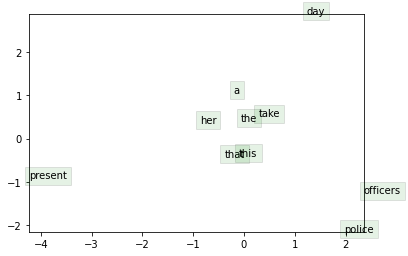

In [29]:
plot_vectors(w2v_skip_gram.W1)

# Previous Test ('Dhaka is the capital of Bangladesh. Delhi is the capital of India. Paris is the capital of France.')

In [28]:
# print('CBOW Results:')
# print('bangladesh - dhaka + france = ', w2v_cbow.check_subtract_prop('bangladesh', 'dhaka', 'paris'))
# print('bangladesh - dhaka + france = ', w2v_cbow.check_subtract_prop('bangladesh', 'dhaka', 'delhi'))
# print('bangladesh - dhaka + france = ', w2v_cbow.check_subtract_prop('paris', 'france', 'dhaka'))
# print('bangladesh - dhaka + france = ', w2v_cbow.check_subtract_prop('france', 'paris', 'bangladesh'))
# # print(w2v_cbow.W1)
# print('dhaka -> ', w2v_cbow.word_with_closest_distance('dhaka'))
# print('delhi -> ', w2v_cbow.word_with_closest_distance('delhi'))
# print('paris -> ', w2v_cbow.word_with_closest_distance('paris'))
# print('---------------------------------')

# print('Skip Gram Results:')
# print('bangladesh - dhaka + france = ', w2v_skip_gram.check_subtract_prop('bangladesh', 'dhaka', 'france'))
# print('bangladesh - dhaka + paris = ', w2v_skip_gram.check_subtract_prop('bangladesh', 'dhaka', 'paris'))
# print('bangladesh - dhaka + delhi = ', w2v_skip_gram.check_subtract_prop('bangladesh', 'dhaka', 'delhi'))
# print('paris - france + dhaka = ', w2v_skip_gram.check_subtract_prop('paris', 'france', 'dhaka'))
# print('france - paris + bangladesh = ', w2v_skip_gram.check_subtract_prop('france', 'paris', 'bangladesh'))
# # print(w2v_cbow.W1)
# print('dhaka -> ', w2v_skip_gram.word_with_closest_distance('dhaka'))
# print('delhi -> ', w2v_skip_gram.word_with_closest_distance('delhi'))
# print('paris -> ', w2v_skip_gram.word_with_closest_distance('paris'))
# # print(w2v_skip_gram.W1)